In [1]:
import os
from scripts.data_processing import load_corpus_parallel
from scripts.text_splitter import TextSplitter
from scripts.retrieval import Retriever
from scripts.reranking import rerank_parents_with_llm
from scripts.rewriting import rewrite_with_mllm
from scripts.utils import save_docs, analyze_kb_types, load_serialized_docs, preview_docs_by_type, render_mm_results
from scripts.prompts import build_retrieval_prompt
from openai import OpenAI

In [2]:
# Configurations
KB_PATH      = "/data/huali_mm/huali_corpus.json"
IMAGE_ROOT   = "/data/huali_mm/"
INPUT_DOCS   = "/data/huali_mm/docs.json"

configs={
"DENSE_MODEL": "./model/e5-large-v2",
"INDEX_PATH" : "faiss_index",
"DENSE_PICK" : 200,         # 稠密召回数
"BM25_PICK"  : 200,         # 稀疏召回数
"TOP_PARENT" : 200,
"k_child"    : 200,
"k_parent"   : 20
}

TOP_TEXT     = 20
TOP_MEDIA    = 5              # image + table 共 5
BATCH        = 5              # 每轮给 LLM 评分的块数（文本时可适当增大）

In [3]:
analyze_kb_types(KB_PATH)

Analyzing KB instances: 100%|█████████| 22304/22304 [00:00<00:00, 914009.21it/s]


一共发现 4 种不同的 type：
  - 'text': 15562 条
  - 'equation': 4407 条
  - 'image': 2116 条
  - 'table': 219 条

注意：有 9 条 type='image' 的记录缺少 'img_path'，示例索引：[651, 652, 3188, 7917, 9119, 10664, 15969, 18126, 18138]

每种 type 的前 5 个实例（完整内容）：

--- Type = 'text' （共 15562 条） ---
1. {'type': 'text', 'text': 'Design for Manufacturability with Advanced Lithography ', 'text_level': 1, 'page_idx': 0, 'book_idx': 0}
2. {'type': 'text', 'text': 'Design for Manufacturability with Advanced Lithography ', 'text_level': 1, 'page_idx': 1, 'book_idx': 0}
3. {'type': 'text', 'text': 'Bei Yu • David Z. Pan ', 'page_idx': 3, 'book_idx': 0}
4. {'type': 'text', 'text': 'Design for Manufacturability with Advanced Lithography ', 'text_level': 1, 'page_idx': 3, 'book_idx': 0}
5. {'type': 'text', 'text': '123 ', 'text_level': 1, 'page_idx': 3, 'book_idx': 0}

--- Type = 'equation' （共 4407 条） ---
1. {'type': 'equation', 'text': '$$\nR = k _ { 1 } \\times \\frac { \\lambda } { N A } ,\n$$', 'text_format': 'latex', 'page_idx':

In [4]:
# docs = load_corpus_parallel(KB_PATH, IMAGE_ROOT) #从KB_PATH, IMAGE_ROOT构建知识库;
# save_docs(docs, INPUT_DOCS) #将构建的知识库保存至INPUT_DOCS
docs = load_serialized_docs(INPUT_DOCS) #从INPUT_DOCS读取构建好的知识库

preview_docs_by_type(docs)


=== TEXT  (共 15474 条) ===
1. page_content='Design for Manufacturability with Advanced Lithography ' metadata={'type': 'text', 'book_idx': 0, 'page_idx': 0, 'text_level': 1}
2. page_content='Design for Manufacturability with Advanced Lithography ' metadata={'type': 'text', 'book_idx': 0, 'page_idx': 1, 'text_level': 1}
3. page_content='Bei Yu • David Z. Pan ' metadata={'type': 'text', 'book_idx': 0, 'page_idx': 3}
4. page_content='Design for Manufacturability with Advanced Lithography ' metadata={'type': 'text', 'book_idx': 0, 'page_idx': 3, 'text_level': 1}
5. page_content='123 ' metadata={'type': 'text', 'book_idx': 0, 'page_idx': 3, 'text_level': 1}

=== IMAGE  (共 2075 条) ===
1. page_content='Fig. 2.8 Overview of our decomposition flow  pipeline_diagram

The diagram outlines an algorithmic process involving multiple steps in a sequential manner aimed at processing input layouts into output masks through various computational stages. The overall objective appears to involve layout op

In [5]:
# chunking
Splitter = TextSplitter()
parents, children = Splitter.split_docs(docs)
# build vector base
ret = Retriever(children, parents, configs)

/data/yfli/code/A-MMRAG/scripts/retrieval.py:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


In [6]:
query = input("\n🔍 请输入查询(空行退出): ").strip()


🔍 请输入查询(空行退出):  浸润式光刻为什么需要多层抗反射层？


In [7]:
# retrival
results = ret.hybrid_retrieval(query)
# rerank
top_text_parents, top_media_parents = rerank_parents_with_llm(
    query=query,
    parents=results,
    n_text=TOP_TEXT,
    n_media=TOP_MEDIA,
    batch=BATCH
)
# relate to equations
top_equations = ret.related_equs(top_text_parents, docs)

print(f"\n最终保留：文本 {len(top_text_parents)} 条，图表 {len(top_media_parents)} 条, 公式 {len(top_equations)} 条")

/data/yfli/code/A-MMRAG/scripts/retrieval.py:106: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  dense_child_hits = self.dense_retriever.get_relevant_documents(query)


稠密检索到 200 个子块，映射到 157 个父块，包含 139 段文本，18 张图像，0 个表格，
稀疏检索到 38 个子块，映射到 20 个父块，包含 20 段文本，0 张图像，0 个表格，


Qwen Scoring: 100%|███████████████████████████| 177/177 [00:18<00:00,  9.70it/s]



关联到同页公式 14 条
1. (equation, p179)  $$
\begin{array} { l } { { \displaystyle O P D _ { \mathrm { a i r } } = \frac { 1 } { 2 } n _ { 1 }…
2. (equation, p179)  $$
\frac { O P D _ { \mathrm { r e s i s t } } } { O P D _ { \mathrm { a i r } } } = \frac { n _ { 1…
3. (equation, p179)  $$
O P D _ { \mathrm { r e s i s t } } \approx { \frac { n _ { 1 } } { n _ { 2 } } } O P D _ { \math…

最终保留：文本 20 条，图表 5 条, 公式 14 条


----------rewriting results--------------


## 🤔 思考过程

嗯，用户询问的是浸润式光刻为什么需要多层抗反射层。这是一个关于半导体制造中光刻技术的专业问题。

在检索到的文本内容中，我看到一些关键信息点：
在book=4 page=342中提到，浸润式系统与干式系统的区别在于耦合介质折射率n_CM更大。这导致可用焦深(DOF_avail)的计算公式中包含了一个与抗反射层相关的项：k3 * λ_coupling_medium / sin²(θ/2) - (n_CM / n_resist) * THK_resist。这个公式明确显示了光阻厚度(THK_resist)对可用焦深的负面影响。

在book=2 page=179的方程中，详细分析了光阻引起的球面像差问题。当光线从空气(n1)进入光阻(n2>n1)时，会产生额外的光程差(OPD_resist)，这个光程差随入射角θ1的四次方增长，表现为三阶球面像差(Z8)。这解释了为什么需要抗反射层来抑制这种效应。

在book=1 page=201讨论了光子在光阻中的统计波动问题(散粒噪声)。计算显示，在193nm波长下曝光一个45nm×45nm接触孔时，每个边长仅对应约24个光子，每个光子波动会导致CD发生显著变化(约4.1%)。这突显了控制反射噪声的重要性。

在book=6 page=37还提到，在248nm光刻中，使用对比度增强层(CEL)可以改善潜像质量。虽然这主要解决对比度问题，但也间接说明薄膜优化对成像质量的影响。

综合这些信息，浸润式光刻需要多层抗反射层的主要原因包括三个物理效应：折射率失配导致的焦深损失、入射角相关的球面像差，以及光子统计波动引起的线宽变异。通过抗反射层可以优化光场在光阻中的分布，抑制这些负面效应。

## 💡 回答


基于提供的检索资料，浸润式光刻需要多层抗反射层（Anti-Reflection Layers）的原因主要与光学特性、成像质量和工艺控制相关，具体分析如下：

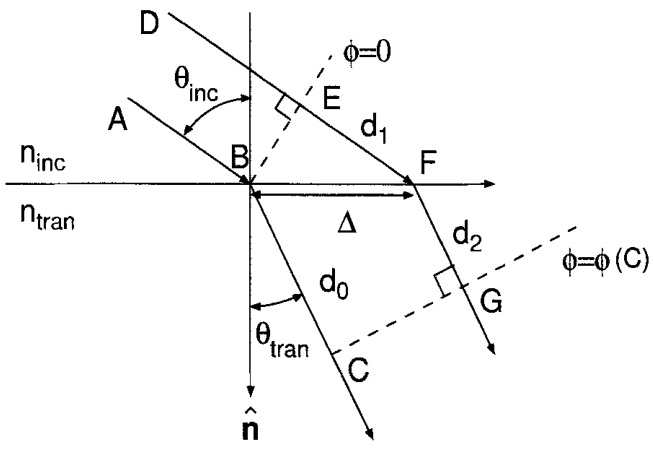

*Figure 2.3: Snells law of refraction. *

### 1. **减少光阻内的反射和驻波效应**
- 光刻过程中，光线从高折射率的浸没液体（如水，(n \approx 1.44)）进入光阻层（(n \approx 1.7)）时，因折射率差异会在界面发生反射。反射光与入射光干涉形成 **驻波（Standing Waves）**，导致光阻内部曝光不均匀。 多层抗反射层可抑制界面反射，减少驻波效应，确保曝光剂量分布的均匀性。

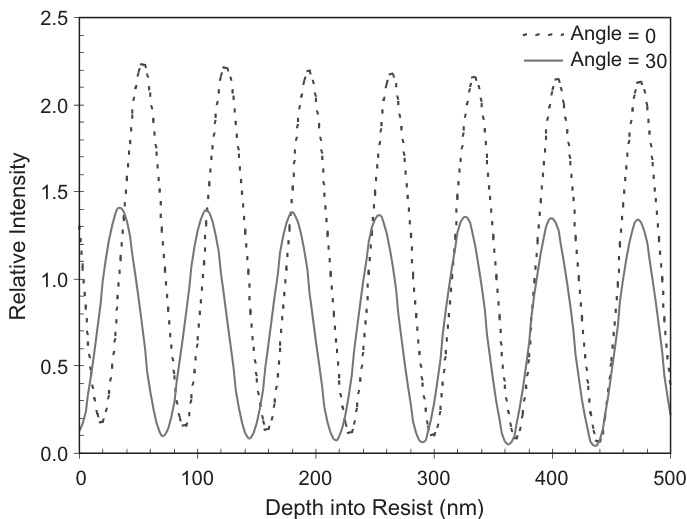

*Figure 4.6 Standing wave intensity within a photoresist film $5 0 0 n m$ of resist on silicon, $\lambda = 2 4 8 n m$ ) as a function of incident angle (s-polarization assumed) *

### 2. **改善焦深（Depth of Focus, DOF）**
- 浸润式系统的可用焦深公式为：[DOF_{avail} = k_3 \frac{\lambda_{coupling\ medium}}{\sin^2(\Theta/2)} - \frac{n_{CM}}{n_{resist}} THK_{resist}\]。其中 (n_{CM}/n_{resist}\) 项表示光阻厚度（(THK_{resist}\)）对焦深的负面影响。抗反射层通过优化光阻内的光传播路径，减轻折射率失配导致的焦深损失。

### 3. **抑制球面像差（Spherical Aberration）**
- 光线通过光阻时，因折射率变化会产生额外光程差（OPD），其近似公式为：[OPD_{resist} \approx \frac{n_1}{n_2} OPD_{air} - \delta \left[ \frac{n_1^2 (n_2^2 - n_1^2)}{8n_2^3} \right] \sin^4 \theta_1\]。此项与入射角 (	heta_1) 的四次方成正比，表现为 **三阶球面像差**（Zernike多项式 (Z_8)）。抗反射层可降低非垂直入射光线的像差，提升成像分辨率。

### 4. **控制散粒噪声（Shot Noise）影响**
- 在极紫外（EUV）或深紫外（DUV）光刻中，光子数量有限。例如，193 nm 曝光下，一个 45 nm × 45 nm 接触孔仅吸收约 590 个光子。光子统计波动（(sqrt{N} \approx 24\)）会导致线宽变异（约 4.1%）。抗反射层通过减少反射损失的光子，提高曝光效率，从而降低噪声对关键尺寸（CD）的影响。

### 总结
多层抗反射层在浸润式光刻中的作用是：
- **物理层面**：减少界面反射和驻波，优化焦深，抑制球面像差。
- **工艺层面**：提升曝光均匀性，降低光子噪声，确保纳米级图形的精确转移。未在资料中明确提及的其他功能（如材料兼容性）需进一步验证。

In [8]:
# build rag prompt
prompt_input = build_retrieval_prompt(query, top_text_parents, top_media_parents, top_equations)
# llm reasoning
print("------------llm reasoning--------------")
deepseek_key = os.getenv("DEEPSEEK_API_KEY")
if not deepseek_key:
    raise RuntimeError("请先确保 DEEPSEEK_API_KEY 已正确设置并激活了 mmrag 环境")

client = OpenAI(api_key=deepseek_key, base_url="https://api.deepseek.com")
response = client.chat.completions.create(
    model="deepseek-reasoner",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": prompt_input},
    ],
    stream=False
)

# print(
#     f"Think: {response.choices[0].message.reasoning_content}"
#     f"\n\nAnswer: {response.choices[0].message.content}"
# )

# rewrite results with mllm
print("------------rewriting results--------------")
result = rewrite_with_mllm(
    answer_text    = response.choices[0].message.content,   # DeepSeek 回答文本
    media_docs     = top_media_parents                      # 5 条图/表父块
)
# rendering
render_mm_results(result, top_media_parents, response)